In [1]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from img2vec import grayscale2emb
import math
import os
import pandas as pd
import joblib
import tensorflow as tf


### check for GPU

In [2]:
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if Intel GPU is available
print("Intel GPU available:", tf.config.list_physical_devices('GPU'))

# Force TensorFlow to use Intel GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['MKLDNN_VERBOSE'] = '1'  # Enable Intel MKL-DNN verbose mode
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'  # Enable Intel oneDNN optimizations
# Set memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        print(e)

TensorFlow version: 2.18.0
Intel GPU available: []


In [3]:
# Define the batch size
batch_size = 64

### Read the data

In [4]:
train_data = pd.read_csv(os.path.join('..', '..', 'data', 'train.csv'))
val_data = pd.read_csv(os.path.join('..', '..', 'data', 'val.csv'))
test_data = pd.read_csv(os.path.join('..', '..', 'data', 'test.csv'))

### Combine the age and gender columns

In [5]:
train_data['combined_label'] = train_data['age'] + '_' + train_data['gender']
val_data['combined_label'] = val_data['age'] + '_' + val_data['gender']
test_data['combined_label'] = test_data['age'] + '_' + test_data['gender']

### remove records with rear combinations

In [6]:
# Check if encoder already exists
if os.path.exists('combined_encoder.pkl'):
    combined_encoder = joblib.load('combined_encoder.pkl')
    print("Combined encoder loaded successfully.")

    # Filter data to include only classes the encoder knows
    train_data_filtered = train_data[train_data['combined_label'].isin(combined_encoder.classes_)]
    val_data_filtered = val_data[val_data['combined_label'].isin(combined_encoder.classes_)]
    test_data_filtered = test_data[test_data['combined_label'].isin(combined_encoder.classes_)]

    # Transform the labels using the loaded encoder
    train_data_filtered['combined_label_encoded'] = combined_encoder.transform(train_data_filtered['combined_label'])
    val_data_filtered['combined_label_encoded'] = combined_encoder.transform(val_data_filtered['combined_label'])
    test_data_filtered['combined_label_encoded'] = combined_encoder.transform(test_data_filtered['combined_label'])
else:
    # Count frequency of each combined label
    label_counts = train_data['combined_label'].value_counts()

    # Find rare combinations (e.g., occurring less than 5 times)
    rare_labels = label_counts[label_counts < 5].index.tolist()
    print(f"Rare combinations: {rare_labels}")

    # Remove rare combinations from all datasets
    train_data_filtered = train_data[~train_data['combined_label'].isin(rare_labels)]
    val_data_filtered = val_data[~val_data['combined_label'].isin(rare_labels)]
    test_data_filtered = test_data[~test_data['combined_label'].isin(rare_labels)]

    # Create and fit a new encoder
    combined_encoder = LabelEncoder()
    train_data_filtered['combined_label_encoded'] = combined_encoder.fit_transform(
        train_data_filtered['combined_label'])

    # Ensure validation and test sets only contain classes seen during training
    val_data_filtered = val_data_filtered[
        val_data_filtered['combined_label'].isin(train_data_filtered['combined_label'])]
    test_data_filtered = test_data_filtered[
        test_data_filtered['combined_label'].isin(train_data_filtered['combined_label'])]

    val_data_filtered['combined_label_encoded'] = combined_encoder.transform(val_data_filtered['combined_label'])
    test_data_filtered['combined_label_encoded'] = combined_encoder.transform(test_data_filtered['combined_label'])

    # Save the encoder
    joblib.dump(combined_encoder, 'combined_encoder.pkl')
    print("Combined encoder created and saved successfully.")

num_classes = len(combined_encoder.classes_)
print(f"Number of combined classes: {num_classes}")
print("Combined classes:", combined_encoder.classes_)

Rare combinations: ['(25, 32)_u', '(8, 23)_u', '(60, 100)_u']
Combined encoder created and saved successfully.
Number of combined classes: 17
Combined classes: ['(0, 2)_f' '(0, 2)_m' '(0, 2)_u' '(15, 20)_f' '(15, 20)_m' '(25, 32)_f'
 '(25, 32)_m' '(38, 43)_f' '(38, 43)_m' '(4, 6)_f' '(4, 6)_m' '(48, 53)_f'
 '(48, 53)_m' '(60, 100)_f' '(60, 100)_m' '(8, 23)_f' '(8, 23)_m']


C:\Users\shayg\AppData\Local\Temp\ipykernel_19628\266600622.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_filtered['combined_label_encoded'] = combined_encoder.fit_transform(


### Add image paths

In [7]:
def construct_img_path(row):
    return os.path.join("..", "..", "data", "faces", row['user_id'],
                        "coarse_tilt_aligned_face." + str(row['face_id']) + "." + row['original_image'])


train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)


### Check if images exist

In [8]:
train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

### Filter out any rows where the image doesn't exist

In [10]:
train_data_filtered = train_data_filtered.merge(
    train_data[['user_id', 'face_id', 'original_image', 'img_path', 'img_exists']], 
    on=['user_id', 'face_id', 'original_image']
)

val_data_filtered = val_data_filtered.merge(
    val_data[['user_id', 'face_id', 'original_image', 'img_path', 'img_exists']], 
    on=['user_id', 'face_id', 'original_image']
)

test_data_filtered = test_data_filtered.merge(
    test_data[['user_id', 'face_id', 'original_image', 'img_path', 'img_exists']], 
    on=['user_id', 'face_id', 'original_image']
)

# Now filter only those that exist
train_data_filtered = train_data_filtered[train_data_filtered['img_exists'] == True]
val_data_filtered = val_data_filtered[val_data_filtered['img_exists'] == True]
test_data_filtered = test_data_filtered[test_data_filtered['img_exists'] == True]

### Extract image paths and labels

In [11]:
train_image_paths = train_data_filtered['img_path'].tolist()
train_labels = train_data_filtered['combined_label_encoded'].values  # Use encoded values

val_image_paths = val_data_filtered['img_path'].tolist()
val_labels = val_data_filtered['combined_label_encoded'].values  # Use encoded values

test_image_paths = test_data_filtered['img_path'].tolist()
test_labels = test_data_filtered['combined_label_encoded'].values  # Use encoded values

### Define function that process features in batches and store them to avoid recomputation

In [12]:
def preprocess_and_save_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading pre-processed features from {output_file}")
        return np.load(output_file)

    print(f"Processing {len(image_paths)} images and saving to {output_file}")
    all_features = []

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1}/{math.ceil(len(image_paths) / batch_size)}")
        batch_features = grayscale2emb(batch_paths)
        all_features.append(batch_features)

    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

### Process and save features

In [13]:
if not os.path.exists('train_features.npy'):
    train_features = preprocess_and_save_features(train_image_paths, 'train_features.npy')
    val_features = preprocess_and_save_features(val_image_paths, 'val_features.npy')
    test_features = preprocess_and_save_features(test_image_paths, 'test_features.npy')
else:
    train_features = np.load('train_features.npy')
    val_features = np.load('val_features.npy')
    test_features = np.load('test_features.npy')


Processing 11851 images and saving to train_features.npy
Processing batch 1/186
Processing batch 2/186
Processing batch 3/186
Processing batch 4/186
Processing batch 5/186
Processing batch 6/186
Processing batch 7/186
Processing batch 8/186
Processing batch 9/186
Processing batch 10/186
Processing batch 11/186
Processing batch 12/186
Processing batch 13/186
Processing batch 14/186
Processing batch 15/186
Processing batch 16/186
Processing batch 17/186
Processing batch 18/186
Processing batch 19/186
Processing batch 20/186
Processing batch 21/186
Processing batch 22/186
Processing batch 23/186
Processing batch 24/186
Processing batch 25/186
Processing batch 26/186
Processing batch 27/186
Processing batch 28/186
Processing batch 29/186
Processing batch 30/186
Processing batch 31/186
Processing batch 32/186
Processing batch 33/186
Processing batch 34/186
Processing batch 35/186
Processing batch 36/186
Processing batch 37/186
Processing batch 38/186
Processing batch 39/186
Processing batch

### Standardize features

In [14]:
if os.path.exists('feature_scaler.pkl'):
    # Load existing scaler
    scaler = joblib.load('feature_scaler.pkl')
    print("Feature scaler loaded successfully.")

    train_features_scaled = scaler.transform(train_features)
    val_features_scaled = scaler.transform(val_features)
    test_features_scaled = scaler.transform(test_features)
else:
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)
    test_features_scaled = scaler.transform(test_features)

    # Save the scaler
    joblib.dump(scaler, 'feature_scaler.pkl')
    print("Feature scaler created and saved successfully.")

Feature scaler created and saved successfully.


### Define a simple softmax model 

In [15]:
model = Sequential([
    Dense(num_classes, activation='softmax', input_shape=(train_features.shape[1],),
          kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 17)             │        34,833 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,833 (136.07 KB)

 Trainable params: 34,833 (136.07 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [16]:
# Make sure all labels are properly encoded as integers
print("Train labels dtype:", train_labels.dtype)
print("First few labels:", train_labels[:5])

# Compute class weights with the encoded integer labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))

# Check the class weight dictionary
print("Class weight dictionary:", class_weight_dict)

Train labels dtype: int64
First few labels: [14  4  6  2  3]
Class weight dictionary: {np.int64(0): np.float64(1.7829095832706485), np.int64(1): np.float64(1.2448529411764706), np.int64(2): np.float64(1.0841643033574238), np.int64(3): np.float64(0.9344740577196026), np.int64(4): np.float64(1.2791149487317863), np.int64(5): np.float64(0.350310375406444), np.int64(6): np.float64(0.4650551347957462), np.int64(7): np.float64(0.9307311709730621), np.int64(8): np.float64(0.7369108319860714), np.int64(9): np.float64(0.839900779588944), np.int64(10): np.float64(1.5736290001327844), np.int64(11): np.float64(2.6915739268680445), np.int64(12): np.float64(2.0624782457361643), np.int64(13): np.float64(2.9290657439446366), np.int64(14): np.float64(2.733794694348328), np.int64(15): np.float64(0.8574632805151581), np.int64(16): np.float64(1.1503591535624151)}


In [17]:
print("Training the model...")
# Define the early stopping callback before training the model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(
    train_features_scaled, train_labels,
    validation_data=(val_features_scaled, val_labels),
    epochs=30,
    batch_size=batch_size,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Training the model...
Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2525 - loss: 2.4147 - val_accuracy: 0.4391 - val_loss: 1.7483
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5166 - loss: 1.3273 - val_accuracy: 0.4958 - val_loss: 1.5971
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6160 - loss: 1.0288 - val_accuracy: 0.5214 - val_loss: 1.5085
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6690 - loss: 0.9057 - val_accuracy: 0.5400 - val_loss: 1.4876
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7110 - loss: 0.7952 - val_accuracy: 0.5440 - val_loss: 1.4656
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7308 - loss: 0.7232 - val_accuracy: 0.5478 - val_loss: 1.4650
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7641 - loss: 0.6684 - val_accuracy: 0.5579 - val_loss: 1.4536
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7884 - loss: 0.6

### Save the model

In [18]:
model.save('softmax_classifier.h5')
print("Model saved successfully.")

Model saved successfully.


### Evaluate the model

In [19]:
print("Evaluating the model on test data...")
test_loss, test_acc = model.evaluate(test_features_scaled, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Evaluating the model on test data...
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3227 - loss: 2.3562
Test Loss: 2.5419
Test Accuracy: 0.2883


### Get predictions

In [20]:
test_predictions = model.predict(test_features_scaled)
test_pred_classes = np.argmax(test_predictions, axis=1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Visualize results

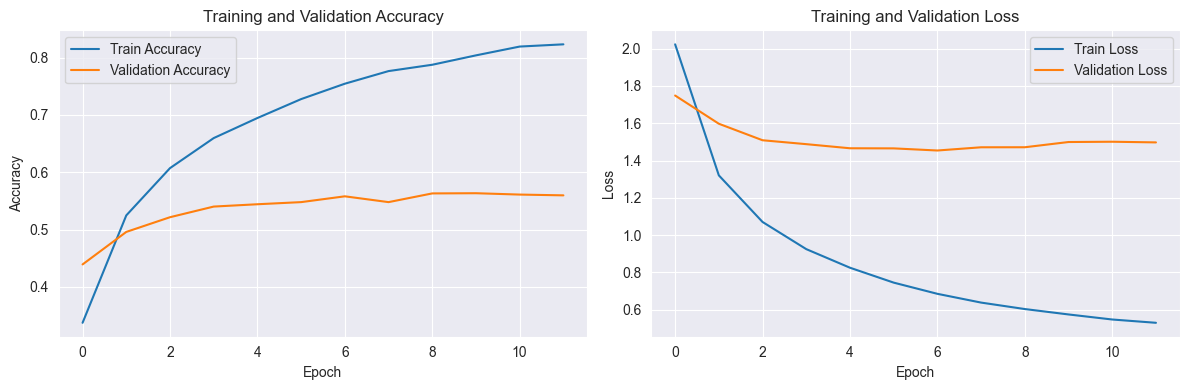

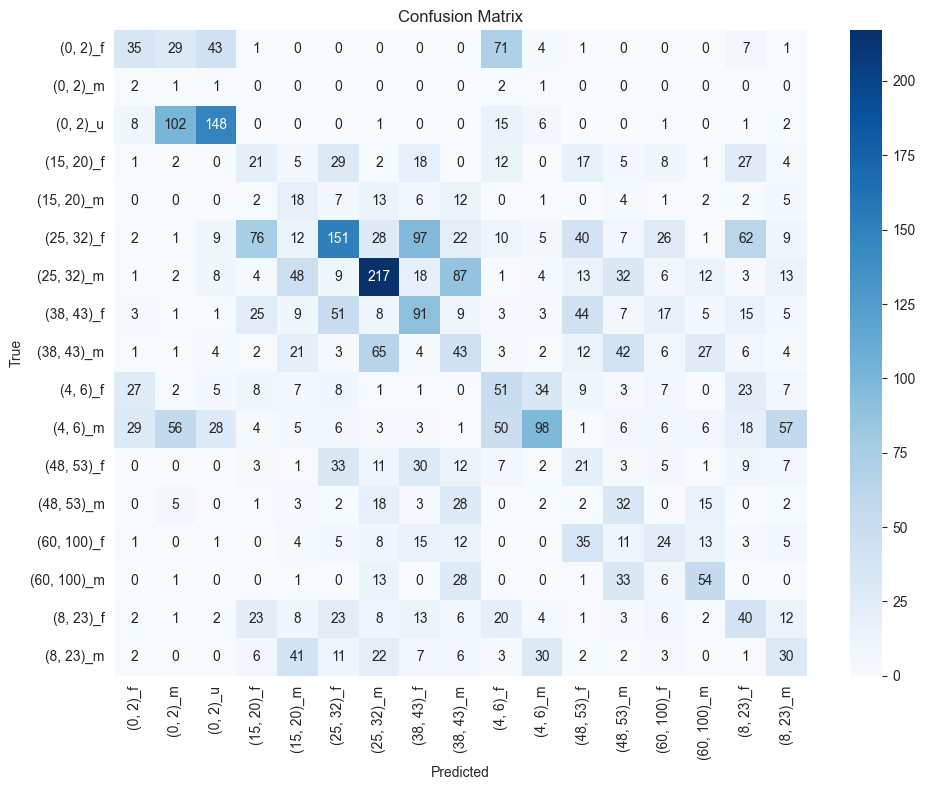

In [21]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=combined_encoder.classes_,
            yticklabels=combined_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

### Classification report

In [22]:
print("Classification Report:")
print(classification_report(test_labels, test_pred_classes, target_names=combined_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

    (0, 2)_f       0.31      0.18      0.23       192
    (0, 2)_m       0.00      0.14      0.01         7
    (0, 2)_u       0.59      0.52      0.55       284
  (15, 20)_f       0.12      0.14      0.13       152
  (15, 20)_m       0.10      0.25      0.14        73
  (25, 32)_f       0.45      0.27      0.34       558
  (25, 32)_m       0.52      0.45      0.48       478
  (38, 43)_f       0.30      0.31      0.30       297
  (38, 43)_m       0.16      0.17      0.17       246
    (4, 6)_f       0.21      0.26      0.23       193
    (4, 6)_m       0.50      0.26      0.34       377
  (48, 53)_f       0.11      0.14      0.12       145
  (48, 53)_m       0.17      0.28      0.21       113
 (60, 100)_f       0.20      0.18      0.19       137
 (60, 100)_m       0.39      0.39      0.39       137
   (8, 23)_f       0.18      0.23      0.20       174
   (8, 23)_m       0.18      0.18      0.18       166

   